<a href="https://colab.research.google.com/github/Vesalon/xla-nmf/blob/main/notebooks/green_minimization_fides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fides

In [2]:
import logging
import os

from matplotlib import pyplot as plt
import numpy as np

from src.hnmf_optimizer import HNMFOptimizer
from src.clusts import result_analysis
from green_model import reconstruct_general, gen_init_params,  gen_bounds, clustering_preprocess


# set true variables

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#       set true variables for generated observations       #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### parameters ###

# # 5 sources
As = np.array([0.4, 0.3,0.2,0.5,0.7])
# positions of the source
Xs = np.array([
  [-0.25,0.45],
  [-0.08,0.2],
  [-0.15,0.25],
  [0.1,-0.1],
  [0.3,0.3]
])

# Advection velocity
u_scaler = 0.05
# U = tf_c(np.array([0.05, 0]))
# Dispersivity
D = np.array([0.005, 0.00125])


### fixed known values ###

# the initial time the sources begin the release
Ts = -10.

Xd = np.array([
[ -0.2,0.6],
[0,0.6],
[0.2,0.6],
[0.4,0.6],
[0.6,0.6],
[-0.2,0.4],
[0,0.4],
[0.2,0.4],
[0.4,0.4],
[0.6,0.4],
[-0.2,0.2],
[0,0.2],
[0.2,0.2],
[0.4,0.2],
[0.6,0.2],
[-0.2,0.0],
[0,0.0],
[0.2,0.0],
[0.4,0.0],
[0.6,0.0],
[-0.2,-0.2],
[0,-0.2],
[0.2,-0.2],
[0.4,-0.2],
[0.6,-0.2],
[-0.2,-0.4],
[0,-0.4],
[0.2,-0.4],
[0.4,-0.4],
[0.6,-0.4]
])

# time values of data
t = np.linspace(0, 20, 80)

# noise to add to 
noise_level = 1e-4


# NMF run

In [4]:
# generate observations from target variables with small noise

noise_level = 1e-4
observations = reconstruct_general(As, Xs, Ts, Xd, t, np.array([u_scaler]), D)
noise = noise_level/2 - noise_level*np.random.rand(*observations.shape)
observations += noise

I0000 00:00:1697684015.073698   12344 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
green_opt = HNMFOptimizer(
    model_fn = reconstruct_general,
    param_generator = gen_init_params,
    bound_generator = gen_bounds,
    input_args = ('t',),
    param_args = ('A_s', 'X_s', 'U', 'D'),
    constants = {'T_s': Ts, 'X_d': Xd},
    min_k = 1,
    max_k = 7,
    nsim = 100
)

res = green_opt(
    t,
    observations,
    opt_case='tr_optimizer',
    fides_opt_options = {
        'maxiter': 1500,
        'xtol': 1e-6,
        'fatol': 1e-10,
        'stepback_strategy': 'truncate',
    }
)
Forclusts = clustering_preprocess(res)

Forclusts = Forclusts.groupby('num_sources', group_keys=False).apply(lambda group: result_analysis(
    group['points'].sum(),
    group['normF'].mean(),
    observations.size,
    group['num_sources'].iloc[0]
))

SIMULATIONS FOR 1 SOURCES TOOK 26.338735818862915 SECONDS
SIMULATIONS FOR 2 SOURCES TOOK 20.252082586288452 SECONDS
SIMULATIONS FOR 3 SOURCES TOOK 25.814491510391235 SECONDS
SIMULATIONS FOR 4 SOURCES TOOK 28.73387050628662 SECONDS
SIMULATIONS FOR 5 SOURCES TOOK 309.5390245914459 SECONDS
SIMULATIONS FOR 6 SOURCES TOOK 270.65149974823 SECONDS
SIMULATIONS FOR 7 SOURCES TOOK 171.98338913917542 SECONDS
Clustering  2
Clustering  3
Clustering  4
Clustering  5
Clustering  6
Clustering  7


In [6]:
res

,fval,sol,grad,hess,normF,num_sources
0,12.581718833709052,"[[1.499998285091702], [[0.016963805330193742, ...","[-17.82871099334946, 0.0007514891085027748, 0....","[[563.8443437819735, -1035.97958430725, -61.45...",9.663588,1
1,12.581983309996724,"[[1.4999834511328556], [[0.016961779355689082,...","[-17.83008145912034, -7.336530232908284e-05, 0...","[[563.8536687054245, -1035.980828694545, -61.4...",9.663690,1
2,12.582031945699564,"[[1.4999807233750835], [[0.016965271005553735,...","[-17.83061769389761, 0.002424386730138318, 0.0...","[[563.8550044867804, -1035.9842290806794, -61....",9.663708,1
3,12.581839752819786,"[[1.4999915028159891], [[0.016963808477723042,...","[-17.82927411865664, 0.0006721114197004121, 0....","[[563.8486918482294, -1035.981066858695, -61.4...",9.663635,1
4,12.58184973306049,"[[1.4999909430589082], [[0.016963712884175423,...","[-17.829492231523997, 0.0011047464790956577, 0...","[[563.8488218561754, -1035.9809112264024, -61....",9.663638,1
...,...,...,...,...,...,...
95,0.0002501332095536473,"[[0.505846891687429, 0.24266389883915343, 0.46...","[-0.03302612249827406, -0.010714367396972083, ...","[[425.8049810912018, 12.261220718270149, 265.7...",0.043088,7
96,3.582064022369935,"[[0.6716159468685127, 0.4894606091933869, 0.17...","[-7.486238898653277, -3.0505633385001008, -4.0...","[[336.0034086151209, 111.56940199093965, 294.4...",5.156263,7
97,0.0919222504215417,"[[0.3535212194567098, 0.23152876905617023, 0.4...","[-6.652642692703705e-05, -0.000414273166205404...","[[562.227951073226, 0.05823109735229211, 1.980...",0.825998,7
98,1.1080952774387471e-06,"[[0.28125298874455773, 0.4122657611797322, 0.4...","[5.55444160145066e-06, -0.00015999322568690475...","[[836.8549671185025, 309.6021882826357, 659.34...",0.002868,7


In [7]:
Forclusts

,num_source,aic_score,avg_sillhouette_score,min_sillhouette_score,reconstruction_loss,centers
0,1,-1.323366e+04,1.000000,1.000000,9.663609,"[1.4999953076601233, 0.016964138721764086, 0.2..."
0,2,-1.573193e+04,1.000000,1.000000,3.409575,"[[0.7655944318869105, 1.253664383459826], [0.1..."
0,3,-1.802942e+04,1.000000,1.000000,1.307954,"[[0.46166506383713446, 0.5184839901694848, 0.9..."
0,4,-2.838404e+04,1.000000,1.000000,0.017478,"[[0.7036251863772911, 0.4873827257132821, 0.41..."
0,5,-3.285937e+04,0.997199,0.986333,0.002706,"[[0.2991776359599604, 0.500009099045669, 0.200..."
0,6,-3.285780e+04,0.751342,-0.327622,0.002705,"[[0.15730101268626376, 0.19594412342580336, 0...."
0,7,inf,0.232798,-0.441623,0.002741,"[[0.4080085704974257, 0.174395023036632, 0.290..."


In [8]:
def plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all, output_dir):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Reconstruction Error [%]', color=color)  # we already handled the x-label with ax1
    ax1.plot(numsources, recs_all, color=color,marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(numsources, avgsilsall, color=color,label='Avg_sil',marker = 'o')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(numsources, minsillsall, color='pink', label='Min_sill', marker='o')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(output_dir+"Selection_plot.png")
    plt.show()

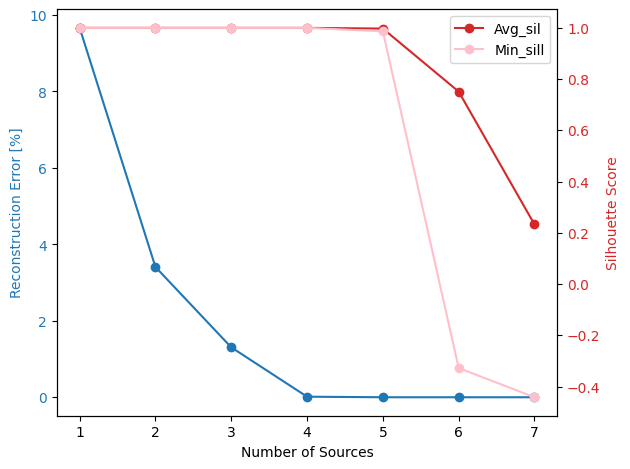

In [9]:
OUTPUTDIR = "Results/"
os.makedirs(OUTPUTDIR,exist_ok=True)

numsources = Forclusts['num_source'].values
avgsilsall    = Forclusts['avg_sillhouette_score'].values
minsillsall   = Forclusts['min_sillhouette_score'].values
recs_all   = Forclusts['reconstruction_loss'].values
plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all,OUTPUTDIR)

In [10]:
Forclusts['centers'].iloc[4]

array([[ 0.29917764,  0.5000091 ,  0.2006966 ,  0.40003249,  0.70000833],
       [-0.07991439,  0.09998775, -0.14989708, -0.25000166,  0.29994055],
       [ 0.19997993, -0.09999486,  0.24982615,  0.44999184,  0.29999168],
       [ 0.04999982,  0.04999982,  0.04999982,  0.04999982,  0.04999982],
       [ 0.00499993,  0.00499993,  0.00499993,  0.00499993,  0.00499993],
       [ 0.00125003,  0.00125003,  0.00125003,  0.00125003,  0.00125003]])

In [11]:
ground_truth=np.vstack([As,Xs.T])
ground_truth

array([[ 0.4 ,  0.3 ,  0.2 ,  0.5 ,  0.7 ],
       [-0.25, -0.08, -0.15,  0.1 ,  0.3 ],
       [ 0.45,  0.2 ,  0.25, -0.1 ,  0.3 ]])